# Implementar un MLP con PyTorch para clasificación basado en el dataset de agresividad

<img src="figs/fig-MLP_XOR.png" width="50%">


1. **Definir los preprocesamientos para el texto**:  
   - convertir a minúsculas
   - normalizar el texto: borrar símbolos, puntuación, caracteres duplicados, etc.

2. **Separar los datos para entrenamiento y prueba**:  
   - Crear los dataset de entrenamiento y test con al función train_test_split 

3. **Construir la matriz de Documento-Término**:  
   - Definir los parámetros para usar unigramas
   - Usar la clase TfidfVectorizer para construir la matriz con los datos de entrenamiento

   
4. **Preparar los lotes de datos (minibatches) para el entrenamiento de la red**:  
   - Definir los minibatches con la matriz TFIDF construida

5. **Definir la arquitectura de la red**:  
   - Definir entradas, salidas,  capas de la red y funciones de activación

6. **Entrenar el modelo**:  
   - Definir los parámetros de las red como: número de épocas, learning_rate, número de neuronas para las capas ocultas, etc.
   
7. **Evaluar el modelo**:  
   - Después del entrenamiento, probar la red con las entradas del conjunto de test y evaluar el desempeño con las métricas: Precisión, Recall, F1-score o F1-Measure y Accuracy.
   


# Definición de los datos y minibatches

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import unicodedata
import re

PUNCTUACTION = ";:,.\\-\"'/"
SYMBOLS = "()[]¿?¡!{}~<>|"
NUMBERS= "0123456789"
SKIP_SYMBOLS = set(PUNCTUACTION + SYMBOLS)
SKIP_SYMBOLS_AND_SPACES = set(PUNCTUACTION + SYMBOLS + '\t\n\r ')

def normaliza_texto(input_str,
                    punct=False,
                    accents=False,
                    num=False,
                    max_dup=2):
    """
        punct=False (elimina la puntuación, True deja intacta la puntuación)
        accents=False (elimina los acentos, True deja intactos los acentos)
        num= False (elimina los números, True deja intactos los acentos)
        max_dup=2 (número máximo de símbolos duplicados de forma consecutiva, rrrrr => rr)
    """
    
    nfkd_f = unicodedata.normalize('NFKD', input_str)
    n_str = []
    c_prev = ''
    cc_prev = 0
    for c in nfkd_f:
        if not num:
            if c in NUMBERS:
                continue
        if not punct:
            if c in SKIP_SYMBOLS:
                continue
        if not accents and unicodedata.combining(c):
            continue
        if c_prev == c:
            cc_prev += 1
            if cc_prev >= max_dup:
                continue
        else:
            cc_prev = 0
        n_str.append(c)
        c_prev = c
    texto = unicodedata.normalize('NFKD', "".join(n_str))
    texto = re.sub(r'(\s)+', r' ', texto.strip(), flags=re.IGNORECASE)
    return texto

# colocar la semilla para la generación de números aleatorios para la reproducibilidad de experimentos
random_state = 12
torch.manual_seed(random_state)
np.random.seed(random_state)

docs = pd.read_json("./data/data_aggressiveness_es.json", lines=True)
X_docs = docs['text']
Y_docs = docs['klass']

vec_tfidf = TfidfVectorizer(analyzer="word", preprocessor=normaliza_texto,  ngram_range=(1,1))
X = vec_tfidf.fit_transform(X_docs)

le = LabelEncoder()
Y = le.fit_transform(Y_docs)

X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.2, stratify= Y, random_state=random_state)

X_train = X_train.toarray()

# Crear minibatches en PyTorch usando DataLoader
def create_minibatches(X, Y, batch_size):
    # Recibe los documentos en X y las etiquetas en Y
    dataset = TensorDataset(X, Y) # Cargar los datos en un dataset de tensores
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader


# Definición de la arquitectura de la red

In [2]:
# Definir la red neuronal en PyTorch heredando de la clase base de Redes Neuronales: Module
class MLP(nn.Module):
    # Definir los parámetros para la creación de la clase MLP
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

        if self.fc1.bias is not None:
            nn.init.zeros_(self.fc1.bias)
        if self.fc2.bias is not None:
            nn.init.zeros_(self.fc2.bias)

        #if torch.cuda.is_avaliable():
        #    self.fc1.weight.to('cuda')
        #    self.fc2.weight.to('cuda')
        #    self.fc1.bias.to('cuda')
        #    self.fc2.bias.to('cuda')
            
    def forward(self, X):
        # Definición del orden de conexión de las capas y aplición de las funciones de activación
        out = self.fc1(X)
        out = self.sigmoid(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Entrenamiento de la red

In [3]:

# TODO: Convertir los datos de entrenamiento y etiquetas a tensores  de PyTorch

X_train2 = torch.from_numpy(X_train)
X_train2 = X_train2.to(torch.float32)
Y_train2 = torch.from_numpy(Y_train)
Y_train2 = Y_train2.to(torch.float32)

# Establecer los parámetros de la red
input_size = X_train2.shape[1]
hidden_size = 2
output_size = 1
epochs = 100    # solo usar 2 épocas, para entrenamiento total usar por ejemplo 1000 épocas
learning_rate = 0.2
batch_size = 32

#if torch.cuda.is_avaliable():
#    X_train2.to('cuda')
#    Y_train2.to('cuda')

# Crear el modelo de la red 
model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# TODO: Definir la función de pérdida
criterion = nn.MSELoss()

# Definir el optimizador
# Parámetros del optimizador: parámetros del modelo y learning rate 
# Stochastic Gradient Descent (SGD)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Entrenamiento
print("Iniciando entrenamiento en PyTorch")

# Poner el modelo en modo de entrenamiento
model.train()  

for epoch in range(epochs):
    lossTotal = 0
    #definir el batch_size
    dataloader = create_minibatches(X_train2, Y_train2, batch_size=batch_size)
    for X_tr, y_tr in dataloader:
        
        # TODO: Inicializar los gradientes en cero para cada época
        optimizer.zero_grad()
        
        # TODO: Propagación hacia adelante
        y_pred = model(X_train2)
        
        # Calcular el error MSE, de acuerdo a lo predicho (y_pred)  y la clase objetivo (y)
        loss = criterion(y_pred, Y_train2)
        
        # TODO: Acumular el error 
        lossTotal += loss.item()
        
        # TODO: Propagación hacia atrás: cálculo de los gradientes de los pesos y bias
        loss.backward()
        
        # TODO: Actualización de los pesos: regla de actualización basado en el gradiente:
        optimizer.step()

    print(f"Época {epoch+1}/{epochs}, Pérdida: {lossTotal/len(dataloader)}")


Iniciando entrenamiento en PyTorch


/home/luis/anaconda3/envs/RNA/lib/python3.13/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([4105])) that is different to the input size (torch.Size([4105, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/luis/anaconda3/envs/RNA/lib/python3.13/site-packages/torch/autograd/graph.py:841: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Época 1/100, Pérdida: 0.20961484647998513
Época 2/100, Pérdida: 0.2049307009970495
Época 3/100, Pérdida: 0.20492794324261274
Época 4/100, Pérdida: 0.20492793792902037
Época 5/100, Pérdida: 0.2049279361963272
Época 6/100, Pérdida: 0.2049279361963272
Época 7/100, Pérdida: 0.2049279361963272
Época 8/100, Pérdida: 0.2049279361963272
Época 9/100, Pérdida: 0.2049279361963272
Época 10/100, Pérdida: 0.2049279361963272
Época 11/100, Pérdida: 0.2049279361963272
Época 12/100, Pérdida: 0.2049279361963272
Época 13/100, Pérdida: 0.2049279361963272
Época 14/100, Pérdida: 0.2049279361963272
Época 15/100, Pérdida: 0.2049279361963272
Época 16/100, Pérdida: 0.2049279361963272
Época 17/100, Pérdida: 0.2049279361963272
Época 18/100, Pérdida: 0.2049279361963272
Época 19/100, Pérdida: 0.2049279361963272
Época 20/100, Pérdida: 0.2049279361963272
Época 21/100, Pérdida: 0.2049279361963272
Época 22/100, Pérdida: 0.2049279361963272
Época 23/100, Pérdida: 0.2049279361963272
Época 24/100, Pérdida: 0.204927936196327

KeyboardInterrupt: 

### Modo para predicción de datos

In [ ]:
# TODO: Transformar el dataset de test con los mismos preprocesamientos al espacio vectorial de entrenamiento
X_test2 = X_test.toarray()
# TODO: Convertir los datos de prueba a tensores de PyTorch
X_test2 = torch.from_numpy(X_test2)
X_test2 = X_test2.to(torch.float32)
 
Y_test2 = torch.from_numpy(Y_test)
Y_test2 = Y_test2.to(torch.float32)

#if torch.cuda.is_avaliable():
#    X_test2.to('cuda')
#    Y_test2.to('cuda')

# Establecer el modo del modelo a "evaluación"
model.eval()

with torch.no_grad():  # No  calcular gradientes 
    # TODO: Hacer la progragación hacia adelante para predecir los datos
    
    y_pred = model(X_test2)

# TODO: Obtener la clase real: Clase biaria 0 o 1
y_pred = torch.where(y_pred>0.5, 1, 0)

### Evaluación

              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       296
         1.0     0.7118    1.0000    0.8316       731

    accuracy                         0.7118      1027
   macro avg     0.3559    0.5000    0.4158      1027
weighted avg     0.5066    0.7118    0.5919      1027

[[  0 296]
 [  0 731]]


/home/luis/anaconda3/envs/RNA/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/luis/anaconda3/envs/RNA/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/luis/anaconda3/envs/RNA/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

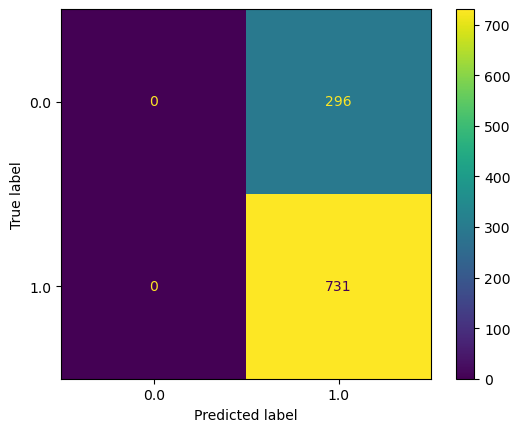

In [ ]:
# TODO: Evaluar el modelo con las predicciones obtenidas y las etiquetas esperadas: 
# classification_report y  matriz de confusión (métricas Precisión, Recall, F1-measaure, Accuracy)

print(classification_report(Y_test2, y_pred, digits=4, zero_division='warn'))

print(confusion_matrix(Y_test2, y_pred))
ConfusionMatrixDisplay.from_predictions(Y_test2, y_pred)